# Mac Address Feature Cleaning

The notebook aims at understanding the mac addresses using a clustering algorithm (k-means) to determine whether the mac addresses are stationary or moving (shoppers).

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import scale

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils

## Import the data and create mac address data frame

In [4]:
mac_address_df = utils.import_mac_addresses()

In [5]:
print('{} mac addresses with {} features'.format(mac_address_df.shape[0], mac_address_df.shape[1]))

154152 mac addresses with 18 features


In [6]:
from msci.cleaning import mac_address_features

In [7]:
signal_df = utils.import_signals()

In [8]:
mac_address_df['start_coordinate'], \
        mac_address_df['end_coordinate'] = \
        mac_address_features.find_start_end_coordinate(signal_df, mac_address_df)

In [9]:
mac_address_df['start_coordinate_y'] = mac_address_df['start_coordinate'].str[1].astype(float)

## Cluster Analysis

In [113]:
FEATURE_LIST = [
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_turning_angle_velocity',
    'av_path_length',
    'total_path_length',
    'av_straightness',
    'turning_angle_density',
    'start_coordinate_y',
]

In [96]:
mac_address_clean_df = mac_address_df[mac_address_df.frequency > 10].dropna(subset=FEATURE_LIST)

In [97]:
mac_address_clean_df.describe()

,frequency,radius_of_gyration,count_density_variance,length_of_stay,is_out_of_hours,av_speed,av_turning_angle,total_turning_angle,av_turning_angle_velocity,av_path_length,total_path_length,av_straightness,av_speed_from_total,turning_angle_density,start_coordinate_y
count,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000,23061.000000
mean,90.699709,57.749790,2.402008,13413.549629,0.026712,0.966003,1.626512,141.177089,-0.004662,26.588731,1567.478145,2.513107,0.270036,0.072905,47.606221
std,203.665588,28.075675,1.461152,18867.794012,0.161243,1.218436,0.363271,381.021519,0.189985,15.977674,2723.290050,1.231534,0.272835,0.051967,37.667514
min,11.000000,0.944355,0.000000,87.000000,0.000000,0.004872,0.084186,0.390607,-3.119614,0.183925,16.185363,1.000000,0.000194,0.001430,0.000000
25%,17.000000,35.941058,1.313579,2120.000000,0.000000,0.435000,1.385630,22.629754,-0.049368,15.964845,539.127871,1.818841,0.103390,0.037817,21.000000
50%,38.000000,61.157028,2.130152,6058.000000,0.000000,0.623315,1.619592,48.251357,-0.000027,22.458634,1020.131638,2.266002,0.198810,0.059034,28.000000
75%,85.000000,79.042536,3.214550,14044.000000,0.000000,0.971918,1.859266,114.902579,0.049170,32.954900,1716.968419,2.864555,0.335048,0.090295,69.000000
max,4344.000000,154.812502,15.556349,86335.000000,1.000000,23.011323,3.141593,8561.045646,3.049002,161.696885,138837.554597,40.620109,3.969383,0.477567,181.000000


We need to scale each feature into a Gaussian distribution.

In [119]:
mac_address_scaled_df = mac_address_clean_df.copy()

for feature in FEATURE_LIST:
    mac_address_scaled_df[feature] = scale(mac_address_clean_df[feature])

c:\users\tvb\envs\venv-msci\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [120]:
samples = mac_address_scaled_df.as_matrix(
    columns=FEATURE_LIST
)

### Kmeans

In [121]:
n_clusters = 2

model = KMeans(n_clusters=n_clusters)
model.fit(samples)
labels = model.predict(samples)

In [122]:
mac_address_clean_df['kmeans_label'] = labels

In [123]:
mac_address_clean_df.kmeans_label.value_counts()

1    17117
0     5944
Name: kmeans_label, dtype: int64

In [124]:
mac_address_clean_df[mac_address_clean_df.manufacturer == 'D-Link International'].kmeans_label.value_counts()

0    26
Name: kmeans_label, dtype: int64

### Gaussian Mixture

In [15]:
samples = mac_address_clean_df.as_matrix(
    columns=FEATURE_LIST
)

In [16]:
model = BayesianGaussianMixture(n_components=3)
model.fit(samples)
labels = model.predict(samples)

In [17]:
model.predict_proba(samples)[:, 0]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         1.00000000e+00,   3.96303965e-04,   1.00000000e+00])

In [18]:
mac_address_clean_df['gaussian_mixture_label'] = labels

In [19]:
mac_address_clean_df.gaussian_mixture_label.value_counts()

2    10361
0     9930
1     2770
Name: gaussian_mixture_label, dtype: int64

### Bayesian

In [15]:
from msci.cleaning.bayesian_inference import sequential

In [114]:
prob_estimates = sequential(0.2, mac_address_clean_df, FEATURE_LIST)

length_of_stay (0.9971635486402236, 6.525381351062642e-09)
length_of_stay (0.9013029010883832, 4.212584884104753e-09)
radius_of_gyration (0.9707325483020307, 2.707541933458795e-10)
radius_of_gyration (0.9987064234317626, 1.2453674306736555e-08)
count_density_variance (0.0, 0.0)
count_density_variance (0.0, 0.0)
av_speed (0.0, 0.0)
av_speed (0.0, 0.0)
av_turning_angle (0.0, 0.0)
av_turning_angle (0.0, 0.0)
av_turning_angle_velocity (0.0, 0.0)
av_turning_angle_velocity (0.0, 0.0)
av_path_length (0.9762205351407932, 8.228880103826607e-09)
av_path_length (0.9998145117719401, 3.2903342230343143e-10)
total_path_length (0.8529270146787322, 3.097677942813261e-11)
total_path_length (0.9708146825580213, 1.1057312476204952e-08)
av_straightness (0.0, 0.0)
av_straightness (0.0, 0.0)
turning_angle_density (0.0, 0.0)
turning_angle_density (0.0, 0.0)
start_coordinate_y (0.9920145458515268, 5.247088495448562e-10)
start_coordinate_y (0.9902901973903211, 2.3141719944899257e-09)
length_of_stay
radius_of_g

In [115]:
mac_address_clean_df['shopper'] = prob_estimates[-1][1]
mac_address_clean_df['bayesian_label'] = mac_address_clean_df['shopper'].apply(lambda x: 1 if x > 0.5 else 0)

In [23]:
mac_address_clean_df[mac_address_clean_df.manufacturer.isin(['D-Link International', 'TP-LINK TECHNOLOGIES CO.,LTD.'])][['shopper', 'kmeans_label', 'gaussian_mixture_label']]

,shopper,kmeans_label,gaussian_mixture_label
4,0.000000e+00,0,1
11,0.000000e+00,0,1
15,0.000000e+00,0,1
37,0.000000e+00,0,1
45,7.018954e-36,0,1
60,7.978549e-12,0,1
62,0.000000e+00,0,1
98,1.228407e-144,0,1
130,6.280873e-08,0,1
195,6.727727e-07,0,1


In [24]:
manufacturer = ['TP-LINK TECHNOLOGIES CO.,LTD.']
manufacturer += ['D-Link International']
mac_address_clean_df[mac_address_clean_df.manufacturer.isin(manufacturer)].is_out_of_hours.value_counts()

1    32
0     7
Name: is_out_of_hours, dtype: int64

## Correlation plots

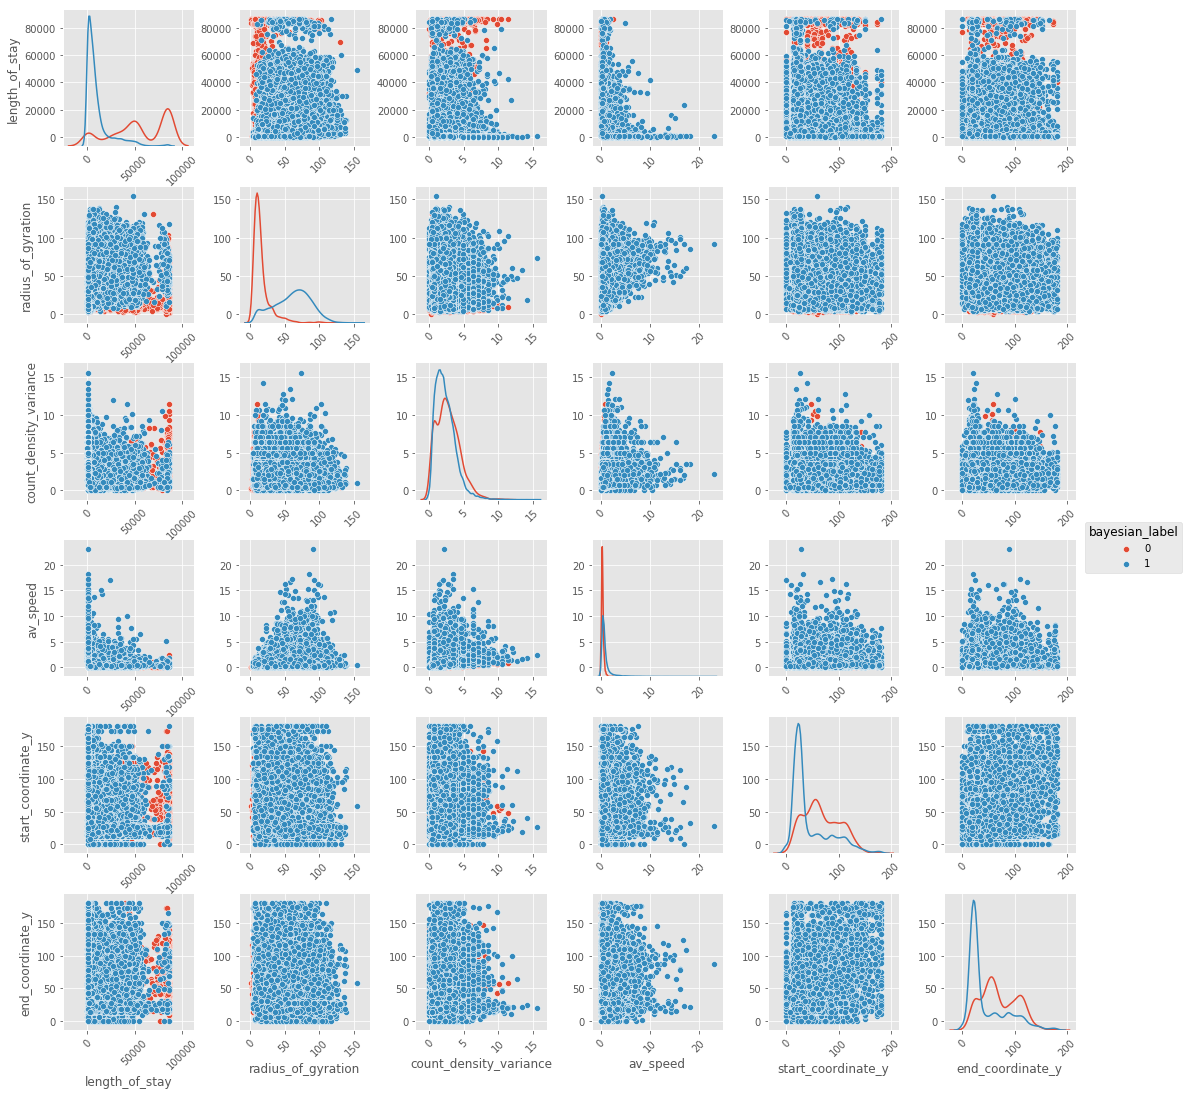

In [116]:
LABEL = 'bayesian_label'

g = sns.pairplot(
    mac_address_clean_df, 
    vars=FEATURE_LIST[:4] + ['start_coordinate_y', 'end_coordinate_y'],
    hue=LABEL, diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

## Venn Diagrams

In [126]:
k_means_stationary_index = mac_address_clean_df[mac_address_clean_df.kmeans_label == 0].index.tolist()
# mixture_stationary_index = mac_address_clean_df[mac_address_clean_df.gaussian_mixture_label == 2].index.tolist()
out_of_hours_stationary_index = mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 1].index.tolist()
bayes_stationary_index = mac_address_clean_df[mac_address_clean_df.shopper < 0.1].index.tolist()

In [127]:
k_means_non_stationary_index = mac_address_clean_df[mac_address_clean_df.kmeans_label == 1].index.tolist()
# mixture_non_stationary_index = mac_address_clean_df[mac_address_clean_df.gaussian_mixture_label == 1].index.tolist()
out_of_hours_non_stationary_index = mac_address_clean_df[mac_address_clean_df.is_out_of_hours == 0].index.tolist()
bayes_non_stationary_index = mac_address_clean_df[mac_address_clean_df.shopper > 0.9].index.tolist()

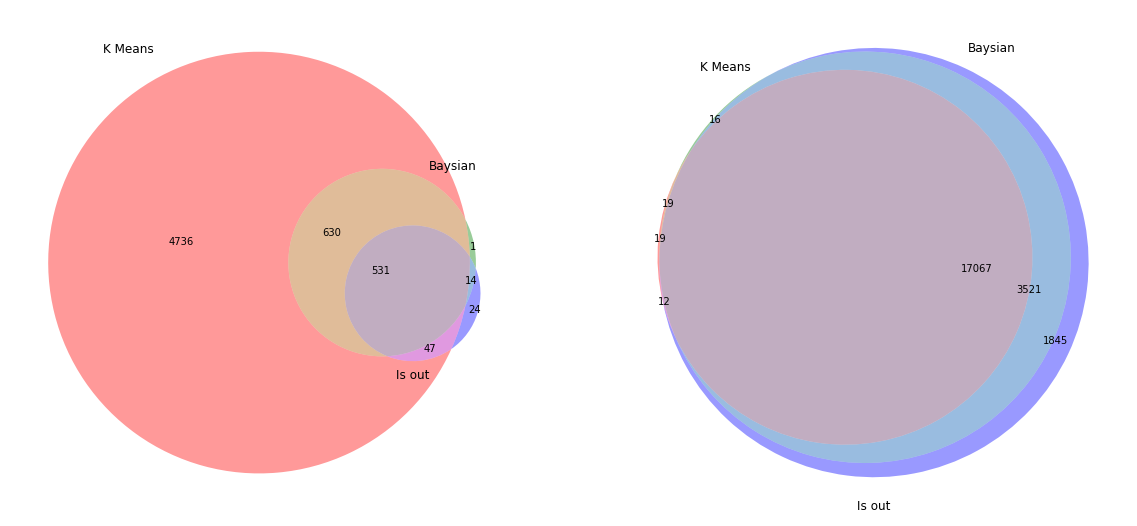

In [128]:
from matplotlib_venn import venn3

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))

set1s = set(k_means_stationary_index)
set2s = set(bayes_stationary_index)
set3s = set(out_of_hours_stationary_index)

venn3([set1s, set2s, set3s], ('K Means', 'Baysian', 'Is out'), ax=ax1)


set1 = set(k_means_non_stationary_index)
set2 = set(bayes_non_stationary_index)
set3 = set(out_of_hours_non_stationary_index)

venn3([set1, set2, set3], ('K Means', 'Baysian', 'Is out'), ax=ax2)

In [129]:
indexes = set2s.difference(set3s)
len(indexes)

In [130]:
from msci.utils import plot

In [131]:
signal_df = utils.import_signals()

In [242]:
indexes = mac_address_clean_df[(mac_address_clean_df.bayesian_label == 0) & (mac_address_clean_df.wifi_type == 'wifiuser')].index.tolist()

     frequency        mac_address                       centroid  \
283        850  78:c3:e9:64:27:0c  [ 227.49411765  100.25705882]   
285        846  04:c2:3e:6b:22:b9  [ 124.06008668  104.55102443]   
290        838  d0:59:e4:0b:37:aa  [ 262.88782816  105.63365155]   
292        837  2c:0e:3d:b0:0e:39  [ 173.92174432   55.71565114]   
293        836  80:65:6d:ca:ce:d5  [ 193.60885167   72.26295853]   
297        830  9c:c1:72:a5:d6:11  [ 157.75240964   78.49457831]   
303        820  78:f8:82:b7:10:a1  [ 293.8945122    72.91646341]   
312        807  18:89:5b:e2:c2:89    [ 71.20260223  61.59727385]   
328        789  38:2d:e8:aa:f7:f3  [ 188.51351922   72.91803971]   
334        781  04:c2:3e:97:6c:0d    [ 57.66965429  61.61352966]   
338        773  28:27:bf:70:34:f7  [ 149.31500647   58.61384217]   
346        764  a4:f1:e8:1d:9a:1e  [ 252.34205934   79.2495637 ]   
348        760  00:18:60:71:1b:28  [ 262.70263158   55.68618421]   
351        752  00:90:4c:c5:12:38  [ 242.5106383

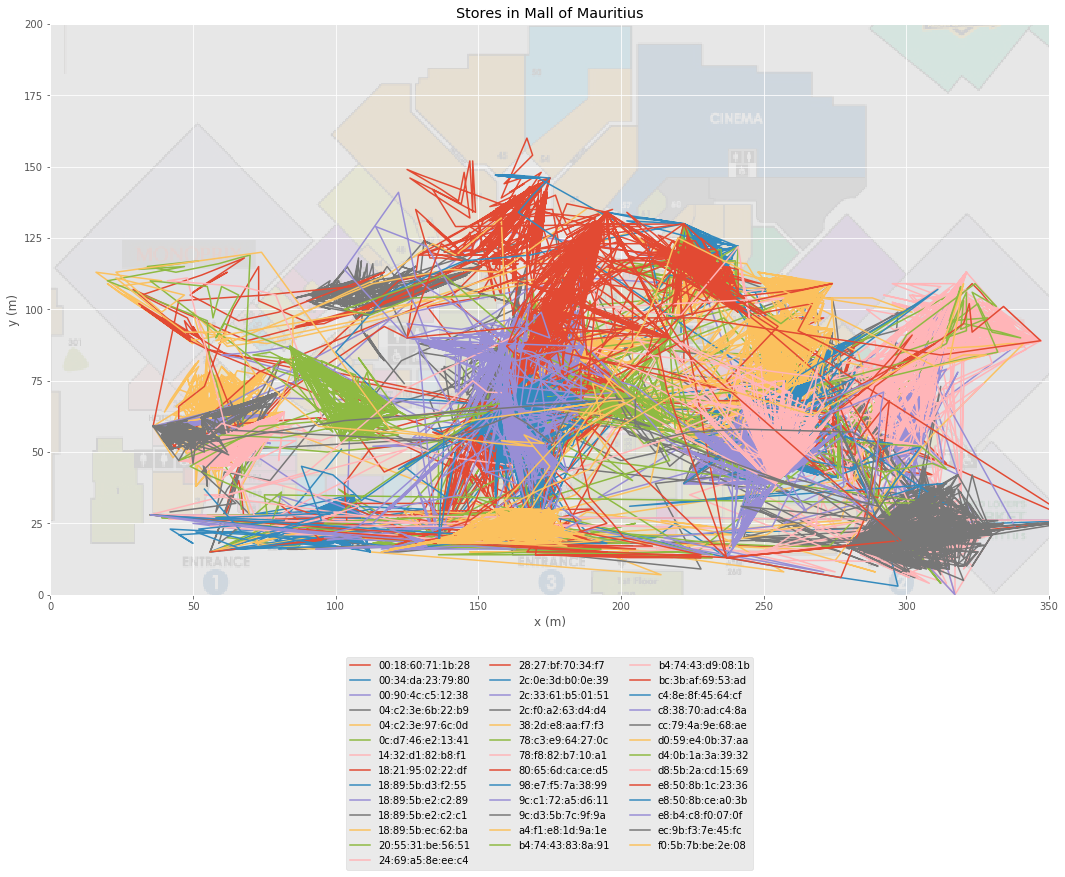

In [249]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
macs = mac_address_clean_df[mac_address_clean_df.index.isin(indexes)].iloc[20:60]
plot.plot_path_jn(signal_df, macs.mac_address, axes=axes, scatter=False)
fig.set_size_inches(20, 10.5)
print(macs)

## PCA

In [24]:
from sklearn.decomposition import PCA

In [66]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(scale(mac_address_clean_df[FEATURE_LIST].as_matrix()))
print(mac_address_clean_df[FEATURE_LIST].as_matrix().shape)
print(projected.shape)

(23061, 12)
(23061, 2)


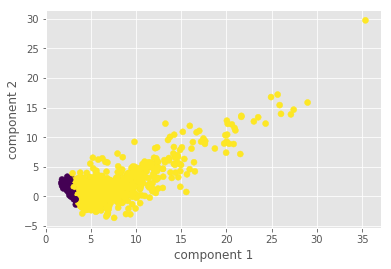

In [67]:
plt.scatter(projected[:1000, 0], projected[:1000, 1], c=mac_address_clean_df.kmeans_label.iloc[:1000])
plt.xlabel('component 1')
plt.ylabel('component 2');

In [68]:
print(pca.components_)
print(pca.explained_variance_)

[[ 0.4488243   0.31934159 -0.24864884  0.16606295 -0.10341291  0.21311024
   0.4469134  -0.02040819 -0.25255481  0.38509532  0.11736353  0.35363785]
 [ 0.28764673  0.1651875   0.46797454  0.05626551  0.11547554 -0.34866792
   0.25903711  0.02044414  0.335145    0.38448782 -0.19746361 -0.4077247 ]]
[ 3.92367374  2.01153542]


In [69]:
list(mac_address_clean_df)

['frequency',
 'mac_address',
 'centroid',
 'radius_of_gyration',
 'manufacturer',
 'count_density_variance',
 'length_of_stay',
 'is_out_of_hours',
 'av_speed',
 'av_turning_angle',
 'total_turning_angle',
 'av_turning_angle_velocity',
 'av_path_length',
 'total_path_length',
 'av_straightness',
 'av_speed_from_total',
 'turning_angle_density',
 'wifi_type',
 'kmeans_label',
 'shopper']